In [1]:
import string
import json
from collections import Counter, defaultdict
import itertools

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from nltk import tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from bs4 import BeautifulSoup

%matplotlib inline

# NOTE: utils is a python package created by me to store helper functions and make notebook more readable and understandable
from utils import process_json_batches, standardize, parse_course_raw_html

## **Stack Overflow part**

## **DOU part**

## **Linkedin part**

## **Coursera part**

#### How have I collected courses data?
I investigated browser network while searching for Data Science courses and found specific request responsible for getting courses data from the server.
Each response contained batch of 30 courses, their short description and metadata. Manually I filtered these requests and stored data in the JSON formatted file (`data/beautified_data.json`). As a result I got 15 batches with 437 courses. The code in the cell below reads file with data, processes it and stores in the pandas.DataFrame.
<br>
<br>
<img src="./images/coursera_courses_page.png" />



In [2]:
# #raw courses json data processing

# data_file = 'data/beautified_data.json'

# batches = []
# with open(data_file) as f:
#     batches_dict = json.load(f)  # key = "batch<id: int>", value = list(courses)   
#     courses_list = list(process_json_batches(batches_dict.values()))
    
# print(f'Number of loaded courses: {len(courses_list)}')

# courses_df = pd.DataFrame(courses_list)
# courses_df.head()

**Note:** I execuded the code above and stored the result in the `data/coursera_courses.json` file, so instead of executing it again you may just read the file:

In [3]:
courses_general_data_df = pd.read_json('data/coursera_courses.json')
courses_general_data_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}]
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}]
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}]
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}]
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}]


Let's take a look at skills frequencies to gain better unerstanding

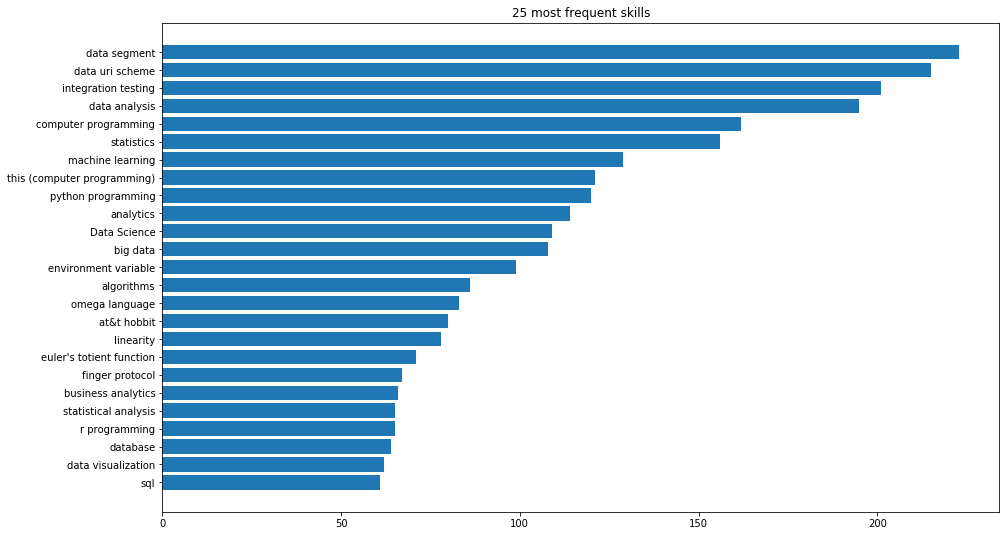

In [4]:
# show skills occurrences
n = 25
skills_counter = Counter(itertools.chain(*courses_general_data_df.skills.map(lambda skills: (s['skillName'] for s in skills))))

most_common_skills = dict(skills_counter.most_common(n)[::-1]) # need to reverse here to plot bars in decreasing order

fig = plt.figure(figsize=(15,9))
plt.barh(list(most_common_skills.keys()), list(most_common_skills.values()))
plt.title(f'{n} most frequent skills')
plt.show()

Let's also check least common skills. And as far as, their frequencies are usually equal to 1, we will just print them

In [5]:
skills_counter.most_common()[:-n-1:-1]       # n least common elements

[('context-free grammar', 1),
 ('google hangouts', 1),
 ('fingerprints', 1),
 ('axosoft', 1),
 ('google wallet', 1),
 ('one month', 1),
 ('language industry', 1),
 ('ml (programming language)', 1),
 ('vest', 1),
 ('entropy (information theory)', 1),
 ('uniform resource identifier', 1),
 ('grayed out', 1),
 ('run time (program lifecycle phase)', 1),
 ('page table', 1),
 ('connect:direct', 1),
 ('list of facebook features', 1),
 ('recordset', 1),
 ('japanese language', 1),
 ('data feed', 1),
 ('spectrum reallocation', 1),
 ('race condition', 1),
 ('crossbridge', 1),
 ('petabyte', 1),
 ('boyer moore string search algorithm', 1),
 ('directaccess', 1)]

## **Experiments with Coursera data**
#### What's the goal?
The idea is to try to apply clustering algorithms to group courses into clusters that potentially may be used as subjects in the university curriculum, using only available Coursera data. <br> We want to check if it's enough to use just courses data to build a curriculums.

#### Data Science program curriculum design experiment

In [6]:
# filter courses with skills only(some courses have empty list of skills)
courses_with_skills_df = courses_general_data_df[courses_general_data_df.skills.map(lambda value: len(value)) > 0].reset_index(drop=True)
courses_with_skills_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}]
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}]
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}]
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}]
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}]


Each course has list with skills it provides and their relevance score (numerical value representing relevance of specific skill in the course). We will use this valuse as features.

In [7]:
courses_with_skills_df.loc[0, 'skills'][:5]

[{'relevanceScore': 1.7358247226999999, 'skillName': 'machine learning'},
 {'relevanceScore': 1.2675839176, 'skillName': 'algorithms'},
 {'relevanceScore': 1.2402567261, 'skillName': 'artificial neural network'},
 {'relevanceScore': 1.2100148486, 'skillName': 'machine learning algorithms'},
 {'relevanceScore': 1.1922643639000001, 'skillName': 'linearity'}]

In [8]:
# define empty matrix, rows represent courses, columns - skills they provide
X = np.zeros(shape=(courses_with_skills_df.shape[0], len(skills_counter.keys())))
X.shape

(413, 3601)

In [9]:
# fill the matrix with skills relevance scores
for i, course in courses_with_skills_df.iterrows():
    for j, skill in enumerate(skills_counter):
        for course_skill in course.skills:
            if course_skill['skillName'] == skill:
                X[i,j] = course_skill['relevanceScore'] 

Among all clustering algorithms I've found `KMeans` with `n_clusters=25` giving the best results.

In [10]:
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [11]:
# display clusters 
# NOTE: these cluster names we defined manually for n_clusters=25
# if you want to change number of clusters, please comment this cell and uncomment the cell below

clusters = ['Mixed data science skills cluster', 'Analytics cluster', 'Bayesian Statistics cluster', 
            'Mixed data science skills cluster', 'Data Visualization', 'r & python cluster', 'Statistics cluster', 'Statistics cluster',
            'Probably outlier(or Exel cluster)', 'Probably outlier(or Big Data cluster)', 'Probably outlier(or Operations Analytics cluster)',
            'Neural Networks and Deep Learning cluster', 'TensorFlow cluster', 'Probably data processing cluster',
            'Probably outlier (or Analytics cluster)', 'Probably outlier(or Unsupervised ML cluster)',
            'Probably outlier(or Probability cluster)', 'Probably outlier(or Python cluster)', 'Probably outlier(or Statistics cluster)',
            'Probably outlier (or Clinical Research cluster)', 'Probably outlier (or Modeling cluster)', 'Google Cloud cluster',
            'Database Management cluster', 'Probably outlier (or Machine Learning: Classification cluster)']                

from colorama import Fore, Style 

                
for i in range(1, len(clusters)):
    print(Fore.RED + '\t\t',clusters[i-1]) 
    print(Style.RESET_ALL) 
    print(sum(kmeans.labels_ == i))
    print(courses_with_skills_df[kmeans.labels_ == i].course_name)
    print()
    print()

		 Mixed data science skills cluster

4
37         Data-driven Decision Making
160             Managing Data Analysis
174       Building a Data Science Team
334    Executive Data Science Capstone
Name: course_name, dtype: object


		 Analytics cluster

8
3                 Introduction to Data Science in Python
52     Understanding Clinical Research: Behind the St...
66                                Inferential Statistics
69                                 Statistical Inference
110    Introduction to Statistics & Data Analysis in ...
118                    Data Analytics for Lean Six Sigma
205    Business Applications of Hypothesis Testing an...
295                                  Data Analysis Tools
Name: course_name, dtype: object


		 Bayesian Statistics cluster

3
20    Google Cloud Platform Big Data and Machine Lea...
39                     How Google does Machine Learning
67    Leveraging Unstructured Data with Cloud Datapr...
Name: course_name, dtype: object


		 Mixed data sci

In [12]:
# # read the comments in the code cell above

# for i in range(1, n_clusters):
#     print(sum(kmeans.labels_ == i))
#     print(courses_with_skills_df[kmeans.labels_ == i].course_name)
#     print()
#     print()

Of course, dimensionality reduction of highdimensional data to 2 dimensions doesn't preserve its real distribution, but at least we may try to check how clusters are approximately located.

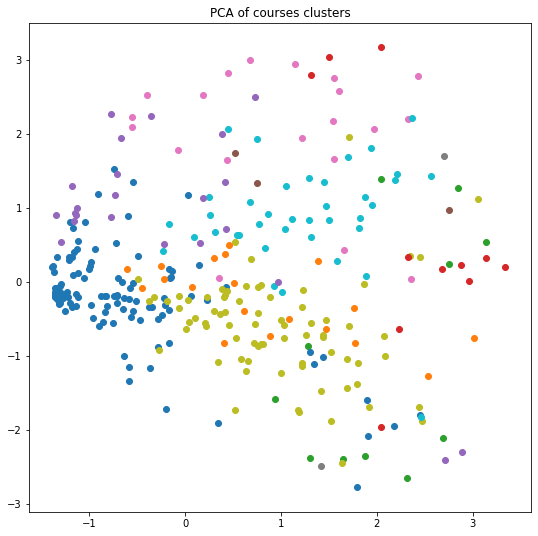

In [13]:
X_pca = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(9,9))
for i in range(0,n_clusters):
    plt.scatter(X_pca[ kmeans.labels_==i, 0],X_pca[kmeans.labels_==i,1])
plt.title('PCA of courses clusters')
plt.show()


#### Course curriculum design experiment
Let's now filter courses that contain "Data science" and view skill they provide. We may think of this skills as must-teach skill for "Intoduction to data science" course.

In [14]:
courses_with_ds_skills_df = courses_with_skills_df[courses_with_skills_df.course_name.map(lambda value: 'data science' in value.lower())].reset_index()
ds_skills_counter = Counter(itertools.chain(*courses_with_ds_skills_df.skills.map(lambda skills: (s['skillName'] for s in skills))))
ds_skills_counter.most_common(25)

[('Data Science', 36),
 ('data segment', 30),
 ('data uri scheme', 30),
 ('data analysis', 30),
 ('computer programming', 23),
 ('integration testing', 22),
 ('statistics', 21),
 ('machine learning', 18),
 ('python programming', 18),
 ('finger protocol', 16),
 ('big data', 15),
 ('r programming', 14),
 ('analytics', 12),
 ('this (computer programming)', 11),
 ('artificial intelligence', 11),
 ('sql', 11),
 ('exploratory data analysis', 11),
 ('data mining', 10),
 ('data model', 10),
 ('database', 10),
 ('ipython', 9),
 ('algorithms', 9),
 ('omega language', 9),
 ('environment variable', 9),
 ('analysis', 9)]

#### Experiments summary
Even though we got some meaningful clusters: Data Visualization, R Programming, Database Management, Statistics ... for the Data Science program curriculum design experiment. Some of them contain different courses that souldn't be placed in the same cluster. So it's not enough to take into account just courses and their skills to predict curriculum.
<br>
<br>Also most common skills taught in coursera "Data Science" courses do not convey a lot of information about how course should be structured and which specific topics to include.
<br>
<br>So our next idea is integratation with job postings.

## **Integration with job postings**
#### Does this dataframe contain enough information for analysis?
Now we have the dataframe with general courses information, but it's necessary to take into account their description and syllabus as well. Why? Because skills list found in the coursera get request response usually contains a lot of noise(words that actually aren't skills). 


#### Fetching course html

In the examples above we were using skills from the course skills list, found in the get request response.
But we can use couse description and syllabus to look for another skill as well.
In the code cell below we will scrape course details page using `parse_course_raw_html` function from `utils`package.
<br>
Code below stores courses descriptions into the `coursera_courses_descriptions.json` file.

In [15]:
# # fetching the course description data

# course_description_map = {
#     'course_slug': [],
#     'course_description': []
# }

# for i, course in courses_general_data_df.iterrows():
#     print(i, course['course_slug']) # print each iteration to see a progress
#     response = requests.get(f'https://www.coursera.org/learn/{course["course_slug"]}')
    
#     soup = BeautifulSoup(response.text)
#     course_description = parse_course_raw_html(soup)
    
#     course_description_map['course_slug'].append(course['course_slug'])
#     course_description_map['course_description'].append(course_description)

# # assert len(course_description_map) == courses_df.shape[0], 'Not all courses html pages were fetched!'

# with open('coursera_courses_descriptions.json', 'w+') as f:
#     json.dump(course_description_map, f)

**Note:** Courses descriptions are already stored in the `data/coursera_courses_descriptions.json` file. Let's check it out.

In [16]:
courses_descriptions_df = pd.read_json('data/coursera_courses_descriptions.json')
courses_descriptions_df.head()

,course_slug,course_description
0,machine-learning,Machine learning is the science of getting com...
1,neural-networks-deep-learning,"If you want to break into cutting-edge AI, thi..."
2,what-is-datascience,The art of uncovering the insights and trends ...
3,python-data-analysis,This course will introduce the learner to the ...
4,convolutional-neural-networks,This course will teach you how to build convol...


Let's merge two dataframes into one.

In [17]:
courses_df = pd.merge(courses_general_data_df, courses_descriptions_df, on='course_slug')
courses_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners,course_description
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}],Machine learning is the science of getting com...
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}],"If you want to break into cutting-edge AI, thi..."
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}],The art of uncovering the insights and trends ...
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}],This course will introduce the learner to the ...
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}],This course will teach you how to build convol...


Let's now convert descriptions to lowercase and replace all punctuation marks and any other symbols with whitespaces using `standardize` function from `utils`package.

In [18]:
# helper function
def standardize_text(text):
    punctuation = string.punctuation
    strange_symbols = ['•', '—', "\n", " ", "\t", "●", "🔸", "nan", "﻿"]
    tokenize_f = tokenize.word_tokenize
    lemmatizer = WordNetLemmatizer() 
    lemmatize_f = lemmatizer.lemmatize
    stop_words = set(stopwords.words('english'))
    
    return standardize(text, punctuation, strange_symbols, 
                       tokenize_f=tokenize_f, lemmatize_f=lemmatize_f, 
                       stop_words=stop_words, replace_symbol=' ')


for i, course in courses_df.iterrows():
    course_skills = (s['skillName'] for s in course.skills)
    text = '.'.join([*course_skills, course.course_description]) # NOTE: we add course skills to it's description and syllabus 
    
    courses_df.loc[i,'description'] = standardize_text(text)

# courses_df.loc[4, 'description']

## TODO: add info what is `all_linked_skills.txt`

In [19]:
with open('data/all_linked_skills.txt', 'r') as f:
    skills_dict = dict.fromkeys((standardize_text(s) for s in f.read().split('\n')), 0)

In [20]:
# # compute how frequently skills appear in course descriptions
# for skill in skills_dict:
#     for description in courses_df['course_slug', 'description']:
#         if f' {skill} ' in f' {description} ':
#             skills_dict[skill] += 1 

In [21]:
# # sort skills by frequencies and restructure dict to create dataftame

# skills = list(skills_dict.items())
# skills.sort(key=lambda t: t[1], reverse=True)
# skills

# d = {
#     'skill': [],
#     'count': []
# }

# for s, c in skills:
#     if c > 0:
#         d['skill'].append(s),
#         d['count'].append(c)
        
# pd.DataFrame(d)#.to_csv('clean_courses_skills.csv')

Compute skills that appear in the course description.

In [22]:
course_computed_skills = defaultdict(set) # key = "course_slug", value = list(skills)

for _, (course_slug, description)  in courses_df[['course_slug', 'description']].iterrows():
    for skill in skills_dict:
        if f' {skill} ' in f' {description} ':
            course_computed_skills[course_slug].add(skill)

d = {
    'course_slug': [],
    'computed_skills': []
}

for c, s in course_computed_skills.items():
    d['course_slug'].append(c)
    d['computed_skills'].append(s)
        
courses_skills_df = pd.DataFrame(d) #.to_csv('clean_courses_skills.csv')
# courses_skills_df.loc[0,'computed_skills']

###  TODO: explain what is score here and also that we can play with tha count field uling different functions to make it more smooth
Read `data/filtered_vacancies_skills.csv` with skills scores.

In [23]:
job_skills_df = pd.read_csv('data/filtered_vacancies_skills.csv')
job_skills_df.head()
# job_skills_df['count'] = np.sqrt(job_skills_df['count'])*10

,Unnamed: 0,skill,count
0,10900,data,3348
1,15594,experience,3193
2,48758,work,2785
3,43922,team,2735
4,20913,skill,0


Compute score for each course, based on skills it provides.

In [24]:
courses_rating_dict = {} # key = "course_slug", value = list(skills)
skills_map = {skill:count for _, (skill, count) in job_skills_df[['skill', 'count']].iterrows()}

for _, (course_slug, skills_list) in courses_skills_df.iterrows():
    for skill in skills_list :
        if skill in skills_map:
            if course_slug in courses_rating_dict:
                courses_rating_dict[course_slug]['count'] += skills_map[skill]
                courses_rating_dict[course_slug]['skills'].append((skill, skills_map[skill]))
            else:
                courses_rating_dict[course_slug] = {
                    'count': skills_map[skill],
                    'skills':[(skill, skills_map[skill])]
                }


len(courses_rating_dict)
# courses_rating_dict

437

In [25]:
# create a dataframe from courses_rating_dict
d = {
    'course_slug': [],
    'scores': [],
    'skills': []
}

for k, v in courses_rating_dict.items():
    d['course_slug'].append(k)
    d['scores'].append(v['count'])
    d['skills'].append(sorted(v['skills'], key=lambda t: t[1], reverse=True))
    
        
course_scores_df = pd.DataFrame(d)
course_scores_df.sort_values(by=['scores'], ascending=False, inplace=True)
# course_scores_df.to_csv('courses_scores_with_weights.csv') 

In [26]:
# drop courses without rating and reviews data
courses_df = courses_df[np.logical_not(np.logical_or(courses_df.ratingCount.isnull(), courses_df.averageFiveStarRating.isnull()))]
courses_df.head()

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills,course_id,course_level,course_name,course_slug,course_workload,partners,course_description,description
0,4.9,56.0,28407.0,115691.0,"[{'relevanceScore': 1.7358247226999999, 'skill...",Gtv4Xb1-EeS-ViIACwYKVQ,None,Machine Learning,machine-learning,,[{'partner_name': 'Stanford University'}],Machine learning is the science of getting com...,machine learning algorithm artificial neural n...
1,4.9,18.0,11607.0,61224.0,"[{'relevanceScore': 1.5504907103, 'skillName':...",W_mOXCrdEeeNPQ68_4aPpA,INTERMEDIATE,Neural Networks and Deep Learning,neural-networks-deep-learning,,[{'partner_name': 'deeplearning.ai'}],"If you want to break into cutting-edge AI, thi...",deep learning artificial neural network python...
2,4.7,6.0,2667.0,16698.0,"[{'relevanceScore': 1.4273084427, 'skillName':...",r0GnHOZaEees-Q6jQMxlrg,BEGINNER,What is Data Science?,what-is-datascience,"3 weeks of study, 2-3 hours/week",[{'partner_name': 'IBM'}],The art of uncovering the insights and trends ...,data science data segment data mining data uri...
3,4.5,18.0,2855.0,12317.0,"[{'relevanceScore': 1.6255460667000001, 'skill...",RZ1S0B0MEeacvQ6cODzg5Q,INTERMEDIATE,Introduction to Data Science in Python,python-data-analysis,,[{'partner_name': 'University of Michigan'}],This course will introduce the learner to the ...,panda python programming computer programming ...
4,4.9,21.0,3033.0,25227.0,"[{'relevanceScore': 1.6032385046000002, 'skill...",kWGvJivBEeeW5RJUyz1uFA,INTERMEDIATE,Convolutional Neural Networks,convolutional-neural-networks,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'deeplearning.ai'}],This course will teach you how to build convol...,convolutional neural network artificial neural...


We want course rating to have an impact on predicted courses as well. <br>
We calculate weighted rating for averageFiveStarRating field using  [WR](https://stats.stackexchange.com/questions/6418/rating-system-taking-account-of-number-of-votes) formula.

In [27]:
# compute weighted rating for averageFiveStarRating field
def weighted_rating(R, v, m, C):
    return (v / (v + m)) * R + (m / (v + m)*C)

R =  courses_df['averageFiveStarRating']
v =  courses_df['ratingCount']
m =  50
C = courses_df['averageFiveStarRating'].mean()

courses_df['WR'] = weighted_rating(R, v, m, C)

## **Our results:**
#### (courses with skills that appear in most Linkedin vacancies)


In [23]:
# merge courses with corresponding scores and multiply score by weighted rating
courses_with_scores_df = pd.merge(courses_df, course_scores_df, on='course_slug')
courses_with_scores_df['scores'] = courses_with_scores_df['scores'] * courses_with_scores_df['WR'] 
courses_with_scores_df.sort_values(by=['scores'], ascending=False, inplace=True)
courses_with_scores_df.head(20)

,averageFiveStarRating,avgLearningHoursAdjusted,commentCount,ratingCount,skills_x,course_id,course_level,course_name,course_slug,course_workload,partners,course_description,description,WR,scores,skills_y
61,4.7,26.0,431.0,2036.0,"[{'relevanceScore': 1.7189451935000002, 'skill...",QoJxNRnoEeW9dA4X94-nLQ,None,Data Visualization and Communication with Tableau,analytics-tableau,"5 weeks, 6-8 hours per week",[{'partner_name': 'Duke University'}],One of the skills that characterizes great bus...,tableau software data uri scheme data analysis...,4.694855,439513.499620,"[(data, 3348), (work, 2785), (business, 2481),..."
88,4.8,30.0,150.0,589.0,"[{'relevanceScore': 1.7899951076, 'skillName':...",SN5tm_tBEeScRyIAC3-PxA,INTERMEDIATE,Process Mining: Data science in Action,process-mining,"6 weeks of study, 3 to 5 hours/week of materia...",[{'partner_name': 'Eindhoven University of Tec...,Process mining is the missing link between mod...,process mining process modeling petri net nett...,4.775378,399708.684335,"[(data, 3348), (business, 2481), (science, 232..."
32,4.7,48.0,148.0,700.0,"[{'relevanceScore': 1.4795783229000001, 'skill...",Mz1ninIDEeeWCg71xNIlJg,ADVANCED,How to Win a Data Science Competition: Learn f...,competitive-data-science,6-10 hours/week,[{'partner_name': 'National Research Universit...,If you want to break into competitive data sci...,feature engineering data analysis feature extr...,4.685689,392192.141809,"[(data, 3348), (experience, 3193), (work, 2785..."
181,4.4,14.0,46.0,139.0,"[{'relevanceScore': 1.4523595278, 'skillName':...",SqmLPbZREeaqPQ5tUH5EoA,INTERMEDIATE,Spatial Data Science and Applications,spatial-data-science,,[{'partner_name': 'Yonsei University'}],Spatial (map) is considered as a core infrastr...,data segment data analysis spatial data analys...,4.422574,391092.649660,"[(data, 3348), (business, 2481), (science, 232..."
261,4.4,13.0,90.0,415.0,"[{'relevanceScore': 1.5599846161, 'skillName':...",NNe5CEW4EeW8ow5lHOiKYQ,INTERMEDIATE,Business Analytics Capstone,wharton-capstone-analytics,"4 weeks of study, 4-5 hours/week",[{'partner_name': 'University of Pennsylvania'}],The Business Analytics Capstone Project gives ...,analytics business analytics data analysis cus...,4.409175,381759.622983,"[(data, 3348), (experience, 3193), (work, 2785..."
263,4.5,13.0,14.0,70.0,"[{'relevanceScore': 1.5999471271, 'skillName':...",lQpeAht8EemDxxJ40YD1SA,INTERMEDIATE,Business Analytics Executive Overview,business-analytics-executive-overview,4-6 hours/week,[{'partner_name': 'University of Illinois at U...,"Businesses run on data, and data offers little...",analytics data segment social network business...,4.493888,381463.643032,"[(data, 3348), (business, 2481), (science, 232..."
34,4.6,24.0,2131.0,8902.0,"[{'relevanceScore': 1.5795197977000002, 'skill...",qi9mnkIJEeWC4g7VhG4bTQ,None,Machine Learning Foundations: A Case Study App...,ml-foundations,"6 weeks of study, 5-8 hours/week",[{'partner_name': 'University of Washington'}],Do you have data and wonder what it can tell y...,machine learning python programming machine le...,4.599360,379690.927198,"[(data, 3348), (experience, 3193), (business, ..."
77,4.7,24.0,556.0,2490.0,"[{'relevanceScore': 1.6895911508, 'skillName':...",GplkvRnqEeW9dA4X94-nLQ,None,Managing Big Data with MySQL,analytics-mysql,"5 weeks, 8-12 hours per week",[{'partner_name': 'Duke University'}],This course is an introduction to how to use r...,sql mysql teradata data uri scheme data analys...,4.695774,377263.196130,"[(data, 3348), (work, 2785), (business, 2481),..."
228,5.0,33.0,1.0,1.0,"[{'relevanceScore': 0.1211824437, 'skillName':...",Cps4A4vKEemLgQoNkRJJng,BEGINNER,Introduction to Accounting Data Analytics and ...,intro-accounting-data-analytics-visual,"Eight weeks of study, three to five hours per ...",[{'partner_name': 'University of Illinois at U...,Accounting has always been about analytical th...,data analysis analytics accounting tableau sof...,4.495422,376792.755645,"[(data, 3348), (business, 248

## TODO: explain the idea

In [24]:
coursesToStudy = []
courseToRating = {}

for _, (course_slug, wr) in courses_with_scores_df[['course_slug', 'WR']].iterrows():
    courseToRating[course_slug] = wr

skills_map = {skill:count for _, (skill, count) in job_skills_df[['skill', 'count']].iterrows()}
for i in range(0, 20):
    courses_rating_dict = {} # key = "course_slug", value = list(skills)

    for _, (course_slug, skills_list) in courses_skills_df.iterrows():
        for skill in skills_list :
            if skill in skills_map:
                if course_slug in courses_rating_dict:
                    courses_rating_dict[course_slug]['count'] += skills_map[skill] * courseToRating.get(course_slug, 0)
                    courses_rating_dict[course_slug]['skills'].append((skill, skills_map[skill]))
                else:
                    courses_rating_dict[course_slug] = {
                        'count':skills_map[skill]*courseToRating.get(course_slug, 0),
                        'skills':[(skill, skills_map[skill])]
                    }
    maxCount = 0
    courseWithMax = {}
    for course_slug in courses_rating_dict:
        if courses_rating_dict[course_slug]['count'] > maxCount:
            courseWithMax = course_slug
            maxCount = courses_rating_dict[course_slug]['count']
    coursesToStudy.append(courseWithMax)
    
    for skillTuple in courses_rating_dict[courseWithMax]['skills']:
        skills_map[skillTuple[0]] /= 2
    
    
coursesToStudy

['analytics-tableau',
 'competitive-data-science',
 'wharton-capstone-analytics',
 'spatial-data-science',
 'process-mining',
 'business-intelligence-tools',
 'deep-learning-business',
 'healthcare-data-quality-governance',
 'ml-regression',
 'nursing-informatics-leaders',
 'data-manipulation',
 'global-statistics',
 'network-biology',
 'analytics-mysql',
 'entrepreneurs-blockchain-technology',
 'business-analytics-executive-overview',
 'build-data-science-team',
 'machine-learning',
 'excel-intermediate-1',
 'uva-darden-market-analytics']